<div style="text-align: center;">
  <h3>Time Series Analysis</h3>
  <h5>Formative Assessment 3</h5>
  <h5><u>By Romand Lansangan</u></h5>
</div>

---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)

# Dataset 1

In [3]:
df1 = pd.read_csv("dataset1.csv")
df1.month = pd.to_datetime(df1.month)
df1.set_index("month", inplace=True)
df1.sort_index(inplace=True)

print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2018-01-31 to 2025-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       96 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB
None


,y
month,
2018-01-31,486.370312
2018-02-28,517.018280
2018-03-31,517.650581
2018-04-30,528.576952
2018-05-31,514.585551


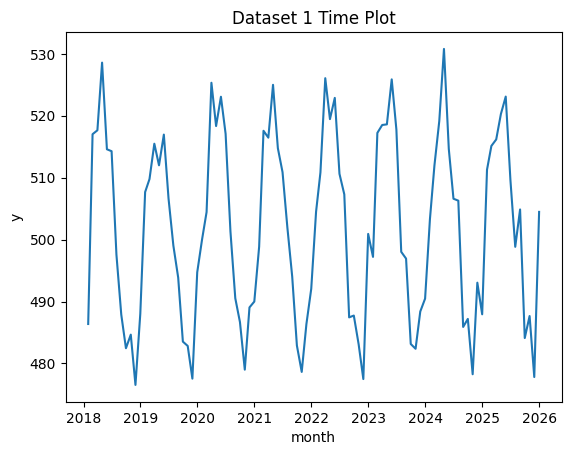

In [4]:
sns.lineplot(df1)
plt.title("Dataset 1 Time Plot")
plt.legend().remove()
plt.ylabel("y");

At first glance, this data heavily relies on seasonality for variation. The magnitude of seasonality remain consistent all throught out so let so we can say that the seasonal component is additive.  

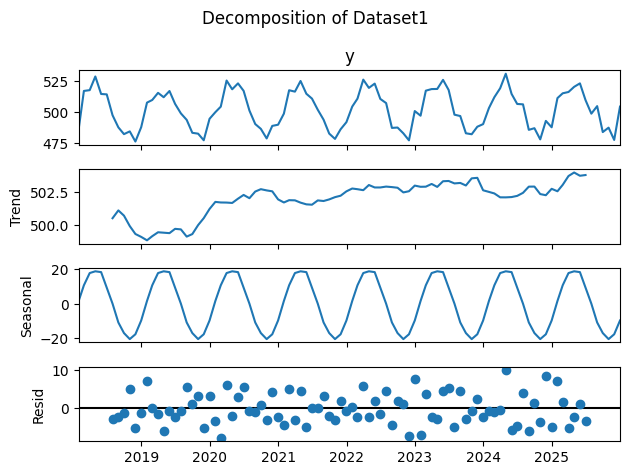

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1['y'], model="additive", period=12)
fig = result.plot()
fig.suptitle("Decomposition of Dataset1")
plt.tight_layout();

Based on the decomposition plot above:
1. Minimal trend occur: Although there is a slight dip around 2019, on the larger scheme of the things, the trend went from 501 to 503--indicating a minimal trend happening.
2. Seaonal component is apparent. To be specific, yearly seasonality happens, flactuating from -20 to 20, in `Dataset1`, (since what we got is a monthly data, period=12). 
3. The variance is consistent all throughtout.
4. Residual is randomly flactuate around 0 from -10 to 10. There's no obvious pattern in the residuals, suggesting the seasonal decomposition has effectively captured the structured components of your time series.

With all the being said, it goes without saying that the trend/mean remain consistent all throughtout the span of data with the variation mostly determined by seasonality. 

Also, since seasonality exist, `dataset1` is non-stationary.

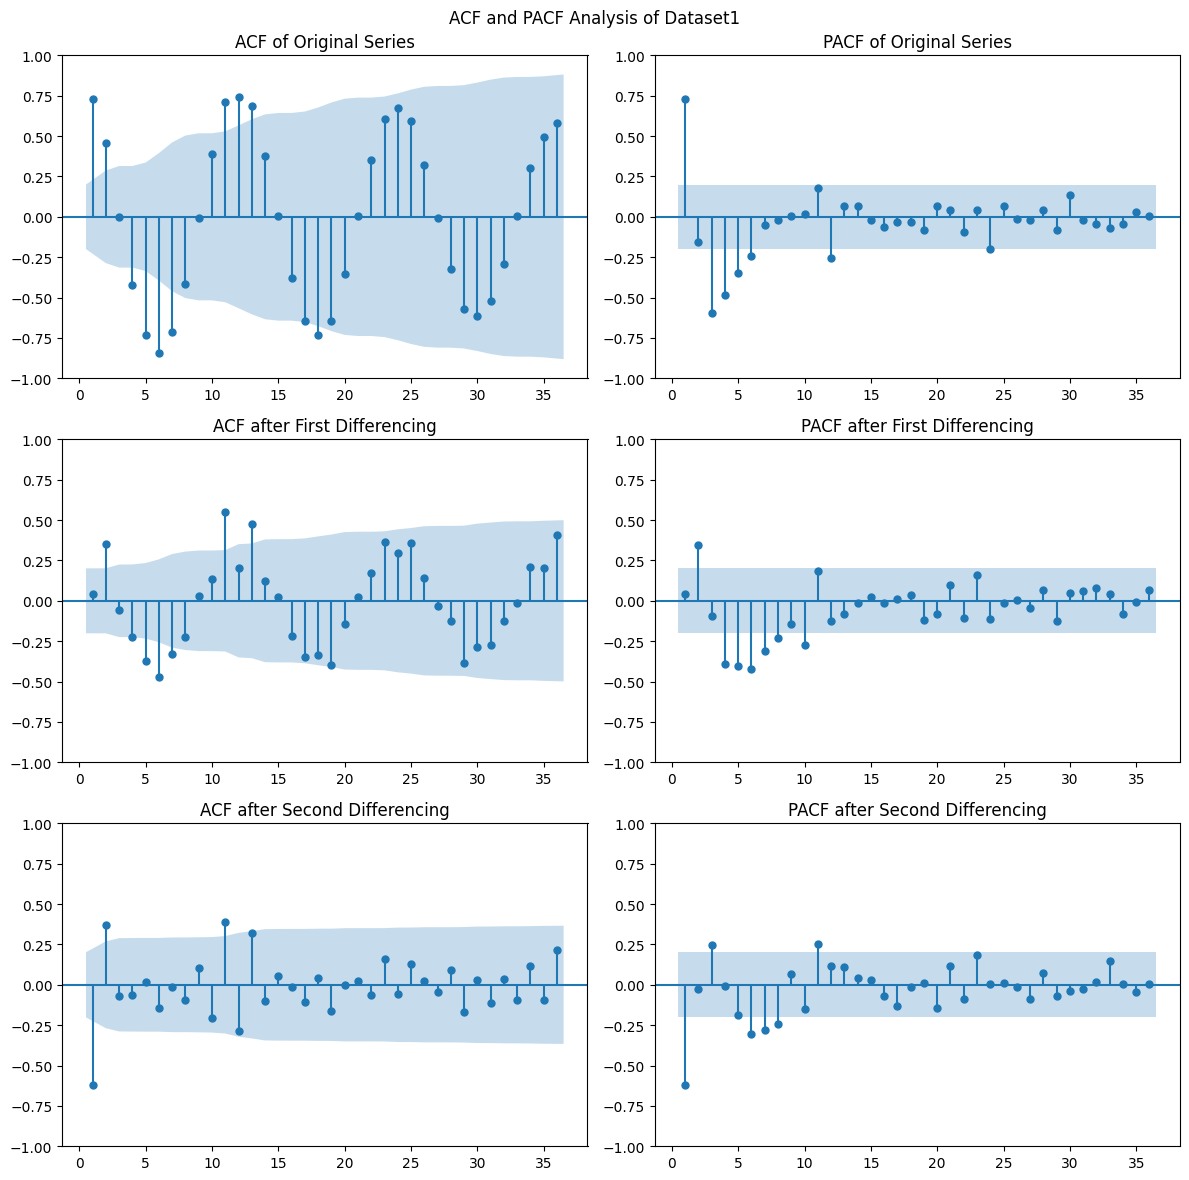

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Original data plots
plot_acf(df1['y'], lags=36, ax=axes[0, 0], zero=False, title='ACF of Original Series')
plot_pacf(df1['y'], lags=36, ax=axes[0, 1], zero=False, title='PACF of Original Series')

# First difference plots
first_dif = (df1 - df1.shift(1)).dropna()
plot_acf(first_dif['y'], lags=36, ax=axes[1, 0], zero=False, title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[1, 1], zero=False, title='PACF after First Differencing')

# Second difference plots
second_dif = (first_dif - first_dif.shift(1)).dropna()
plot_acf(second_dif['y'], lags=36, ax=axes[2, 0], zero=False, title='ACF after Second Differencing')
plot_pacf(second_dif['y'], lags=36, ax=axes[2, 1], zero=False, title='PACF after Second Differencing')

fig.suptitle('ACF and PACF Analysis of Dataset1', y=0.98)
plt.tight_layout()
plt.show()

Based on these plots, I can determine:

- **d=1**: First differencing removes most trend. Second differencing shows negative lag-1 spike indicating over-differencing.

Just basing on the oscilating ACF, we can say that seasonality is apparent.

**Period=12**: ACF of first-difference series shows a significant spike at lag 12. Now let us conduct seasonal differencing for the rest of the paramaters.

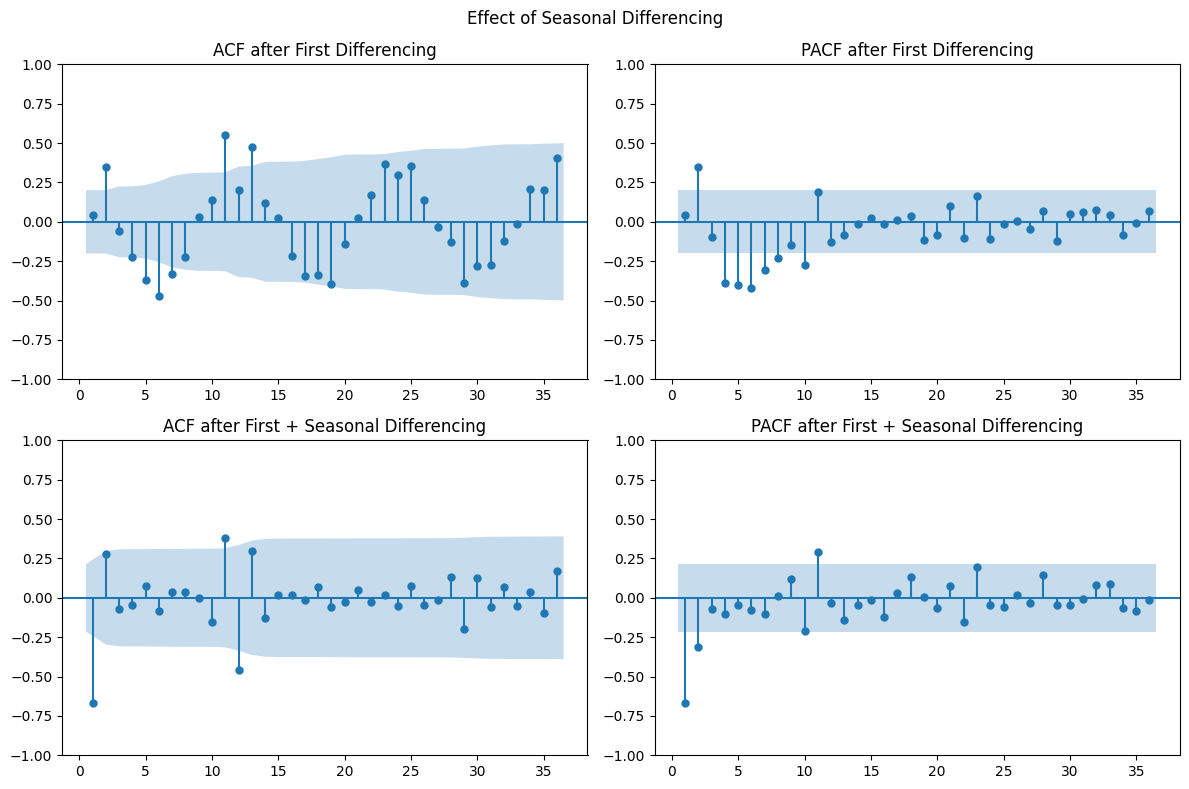

In [7]:
first_dif = (df1 - df1.shift(1)).dropna()

seasonal_dif = (first_dif - first_dif.shift(12)).dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before
plot_acf(first_dif['y'], lags=36, ax=axes[0, 0], zero=False, 
         title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[0, 1], zero=False, 
          title='PACF after First Differencing')

# After
plot_acf(seasonal_dif['y'], lags=36, ax=axes[1, 0], zero=False, 
         title='ACF after First + Seasonal Differencing')
plot_pacf(seasonal_dif['y'], lags=36, ax=axes[1, 1], zero=False, 
          title='PACF after First + Seasonal Differencing')

plt.suptitle('Effect of Seasonal Differencing', y=0.98)
plt.tight_layout()
plt.show()

- **D=1**: Seasonal differencing is effective due to significant reduction in seasonal spikes at lags 12, 24, and 36 in both ACF and PACF plots. The strong seasonal pattern visible in the first-differenced series is largely eliminated after seasonal differencing.

- **P=1**: The PACF after seasonal differencing shows some remaining structure at seasonal lags, particularly around lag 12, suggesting a seasonal AR(1) component may be appropriate.

- **Q=1**: The ACF after seasonal differencing shows a significant spike around lag 12, indicating a seasonal MA(1) component would help model remaining seasonal effects.

- **p=2**: The PACF of the first-differenced series shows significant spikes at lag 2 followed by a cutoff, indicating an AR(2) process for the non-seasonal component.

- **q=1**: The strong negative spike at lag 1 in the ACF after both differencing operations suggests an MA(1) term would be appropriate.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

models = [
    # models from previous analysis
    ((1,1,1), (1,1,1,12), "SARIMA(1,1,1)(1,1,1)12"),
    ((2,1,1), (1,1,1,12), "SARIMA(2,1,1)(1,1,1)12"),
    
    # Models without seasonal MA term
    ((1,1,1), (1,1,0,12), "SARIMA(1,1,1)(1,1,0)12"),
    ((2,1,1), (1,1,0,12), "SARIMA(2,1,1)(1,1,0)12"),
    
    # Models without seasonal AR term
    ((1,1,1), (0,1,1,12), "SARIMA(1,1,1)(0,1,1)12"),
    ((2,1,1), (0,1,1,12), "SARIMA(2,1,1)(0,1,1)12"),
    
    # Simpler models
    ((1,1,0), (1,1,0,12), "SARIMA(1,1,0)(1,1,0)12"),
    ((0,1,1), (0,1,1,12), "SARIMA(0,1,1)(0,1,1)12"),
    
]

model_names = []
aic_values = []
bic_values = []
model_params = []
model_se = []
model_pvalues = []
model_convergence = []

for order, seasonal_order, name in models:
    try:
        model = SARIMAX(df1['y'], order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        
        model_names.append(name)
        aic_values.append(round(result.aic, 3))
        bic_values.append(round(result.bic, 3))
        
        params = result.params
        se = result.bse
        pvalues = result.pvalues
        
        model_params.append(params.to_dict())
        model_se.append(se.to_dict())
        model_pvalues.append(pvalues.to_dict())
        
        # Check for convergence issues
        max_se = se.max()
        model_convergence.append("Issue" if max_se > 10 else "OK")
        
        print(f"Fitted {name}")
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        model_names.append(name)
        aic_values.append(np.nan)
        bic_values.append(np.nan)
        model_params.append({})
        model_se.append({})
        model_pvalues.append({})
        model_convergence.append("Failed")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Model': model_names,
    'AIC': aic_values,
    'BIC': bic_values,
    'Parameters': model_params,
    'Std Errors': model_se,
    'P-values': model_pvalues,
    'Convergence': model_convergence
})

# Sort by AIC
results_df = results_df.sort_values('AIC')

# Display the results
results_df[['Model', 'AIC', 'BIC', 'Convergence']]

Fitted SARIMA(1,1,1)(1,1,1)12
Fitted SARIMA(2,1,1)(1,1,1)12
Fitted SARIMA(1,1,1)(1,1,0)12
Fitted SARIMA(2,1,1)(1,1,0)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(1,1,1)(0,1,1)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(2,1,1)(0,1,1)12
Fitted SARIMA(1,1,0)(1,1,0)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(0,1,1)(0,1,1)12


,Model,AIC,BIC,Convergence
0,"SARIMA(1,1,1)(1,1,1)12",511.883,523.977,Issue
1,"SARIMA(2,1,1)(1,1,1)12",513.034,527.547,Issue
4,"SARIMA(1,1,1)(0,1,1)12",521.733,531.408,Issue
5,"SARIMA(2,1,1)(0,1,1)12",523.636,535.731,Issue
2,"SARIMA(1,1,1)(1,1,0)12",532.669,542.344,OK
3,"SARIMA(2,1,1)(1,1,0)12",534.629,546.723,OK
7,"SARIMA(0,1,1)(0,1,1)12",540.599,547.856,Issue
6,"SARIMA(1,1,0)(1,1,0)12",573.443,580.700,OK


The logic is that if any parameter in the model has a standard error greater than 10, it's flagged as having an "Issue" in the convergence column.

In [9]:
model = SARIMAX(df1['y'], order=(1,1,1), seasonal_order=(1,1,0,12))

results = model.fit(disp=False)
print("SARIMA(1,1,1)(1,1,0)12 Results:")
print("="*50)
print(f"AIC: {results.aic:.3f}")
print(f"BIC: {results.bic:.3f}")
print("\nParameter Estimates:")
print("-"*50)
print(results.summary().tables[1])

SARIMA(1,1,1)(1,1,0)12 Results:
AIC: 532.669
BIC: 542.344

Parameter Estimates:
--------------------------------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5635      0.095     -5.934      0.000      -0.750      -0.377
ma.L1         -0.9869      0.077    -12.829      0.000      -1.138      -0.836
ar.S.L12      -0.6902      0.083     -8.273      0.000      -0.854      -0.527
sigma2        27.6902      5.658      4.894      0.000      16.600      38.780


### SARIMA(1,1,1)(1,1,0)12 Model Analysis

**Fit Statistics:**
- AIC: 532.669, BIC: 542.344
- All parameters highly significant (p<0.001)

**Parameter Estimates and Interpretation:**
- **AR(1) = -0.5635** (SE: 0.095): The negative coefficient reflects the oscillatory patterns visible in the original time series, where values tend to reverse direction from one month to the next.

- **MA(1) = -0.9869** (SE: 0.077): This near-unity coefficient indicates strong short-term correction effects, aligning with the sharp fluctuations observed in the differenced series.

- **Seasonal AR(1) = -0.6902** (SE: 0.083): Captures the clear yearly seasonality evident in the decomposition plot. The negative coefficient indicates seasonal reversals.

- **d=1, D=1**: The need for both regular and seasonal differencing confirms the non-stationary seasonal components identified in our initial decomposition.

This model effectively captures the minimal upward trend, strong seasonal pattern, and short-term fluctuations that characterize the dataset. The parameter values align with the visual patterns observed in both the original and differenced series.

In [10]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

def plot_residual_analysis(model, figsize=(15, 10), lags=15, skip_initial=0):
    """
    Residual analysis for ARIMA/SARIMA models.
    
    Parameters:
    -----------
    model : ARIMA/SARIMA fitted model from statsmodels
    figsize : tuple, figure size (width, height)
    lags : int, number of lags for ACF/PACF and Ljung-Box test
    skip_initial : int, number of initial observations to skip (default=0)
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    
    residuals = model.resid[skip_initial:]
    fitted = model.fittedvalues[skip_initial:]
    
    fig = plt.figure(figsize=figsize)
    
    # 1. Residuals over time
    ax1 = plt.subplot(3, 2, 1)
    residuals.plot(ax=ax1, color='steelblue', alpha=0.7)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax1.set_title('Residuals Over Time')
    ax1.set_ylabel('Residuals')
    ax1.grid(True, alpha=0.3)
    
    # 2. Histogram with normal overlay
    ax2 = plt.subplot(3, 2, 2)
    ax2.hist(residuals, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    mu, std = stats.norm.fit(residuals)
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, 
             label=f'N(μ={mu:.2f}, σ={std:.2f})')
    ax2.set_title('Histogram of Residuals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Q plot
    ax3 = plt.subplot(3, 2, 3)
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Normal Q-Q Plot')
    ax3.grid(True, alpha=0.3)
    
    # 4. Residuals vs Fitted
    ax4 = plt.subplot(3, 2, 4)
    ax4.scatter(fitted, residuals, alpha=0.5, color='steelblue')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax4.set_title('Residuals vs Fitted Values')
    ax4.set_xlabel('Fitted Values')
    ax4.set_ylabel('Residuals')
    ax4.grid(True, alpha=0.3)
    
    # 5. ACF
    ax5 = plt.subplot(3, 2, 5)
    plot_acf(residuals, lags=lags, ax=ax5, alpha=0.05)
    ax5.set_title('ACF of Residuals')
    ax5.grid(True, alpha=0.3)
    
    # 6. PACF
    ax6 = plt.subplot(3, 2, 6)
    plot_pacf(residuals, lags=lags, ax=ax6, alpha=0.05, method='ywm')
    ax6.set_title('PACF of Residuals')
    ax6.grid(True, alpha=0.3)
    
    title = f'{model.model.__class__.__name__} Residual Analysis'
    if skip_initial > 0:
        title += f' (skipped first {skip_initial} obs)'
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Diagnostic statistics
    print("=" * 50)
    print("RESIDUAL DIAGNOSTICS")
    if skip_initial > 0:
        print(f"(Skipping first {skip_initial} observations)")
    print("=" * 50)
    print(f"Mean: {residuals.mean():.6f}")
    print(f"Std:  {residuals.std():.4f}")
    print(f"Skew: {stats.skew(residuals):.4f}")
    print(f"Kurt: {stats.kurtosis(residuals):.4f}")
    
    # Shapiro-Wilk test
    stat, p = stats.shapiro(residuals[:5000])
    print(f"\nShapiro-Wilk: stat={stat:.4f}, p={p:.4f}")
    
    # Ljung-Box test
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print(f"\nLjung-Box test (H0: no autocorrelation):")
    print(lb_test[['lb_stat', 'lb_pvalue']].round(4))
    
    return fig

RESIDUAL DIAGNOSTICS
(Skipping first 1 observations)
Mean: -2.969244
Std:  24.1245
Skew: -8.1439
Kurt: 72.1668

Shapiro-Wilk: stat=0.3125, p=0.0000

Ljung-Box test (H0: no autocorrelation):
    lb_stat  lb_pvalue
1    0.4635     0.4960
2    1.6012     0.4490
3    1.9041     0.5926
4    1.9232     0.7499
5    1.9578     0.8549
6    2.0979     0.9105
7    2.4448     0.9312
8    2.5008     0.9617
9    2.7394     0.9737
10   2.8331     0.9851
11   5.1778     0.9223
12   5.6749     0.9316
13   5.6794     0.9570
14   5.9604     0.9675
15   5.9769     0.9801


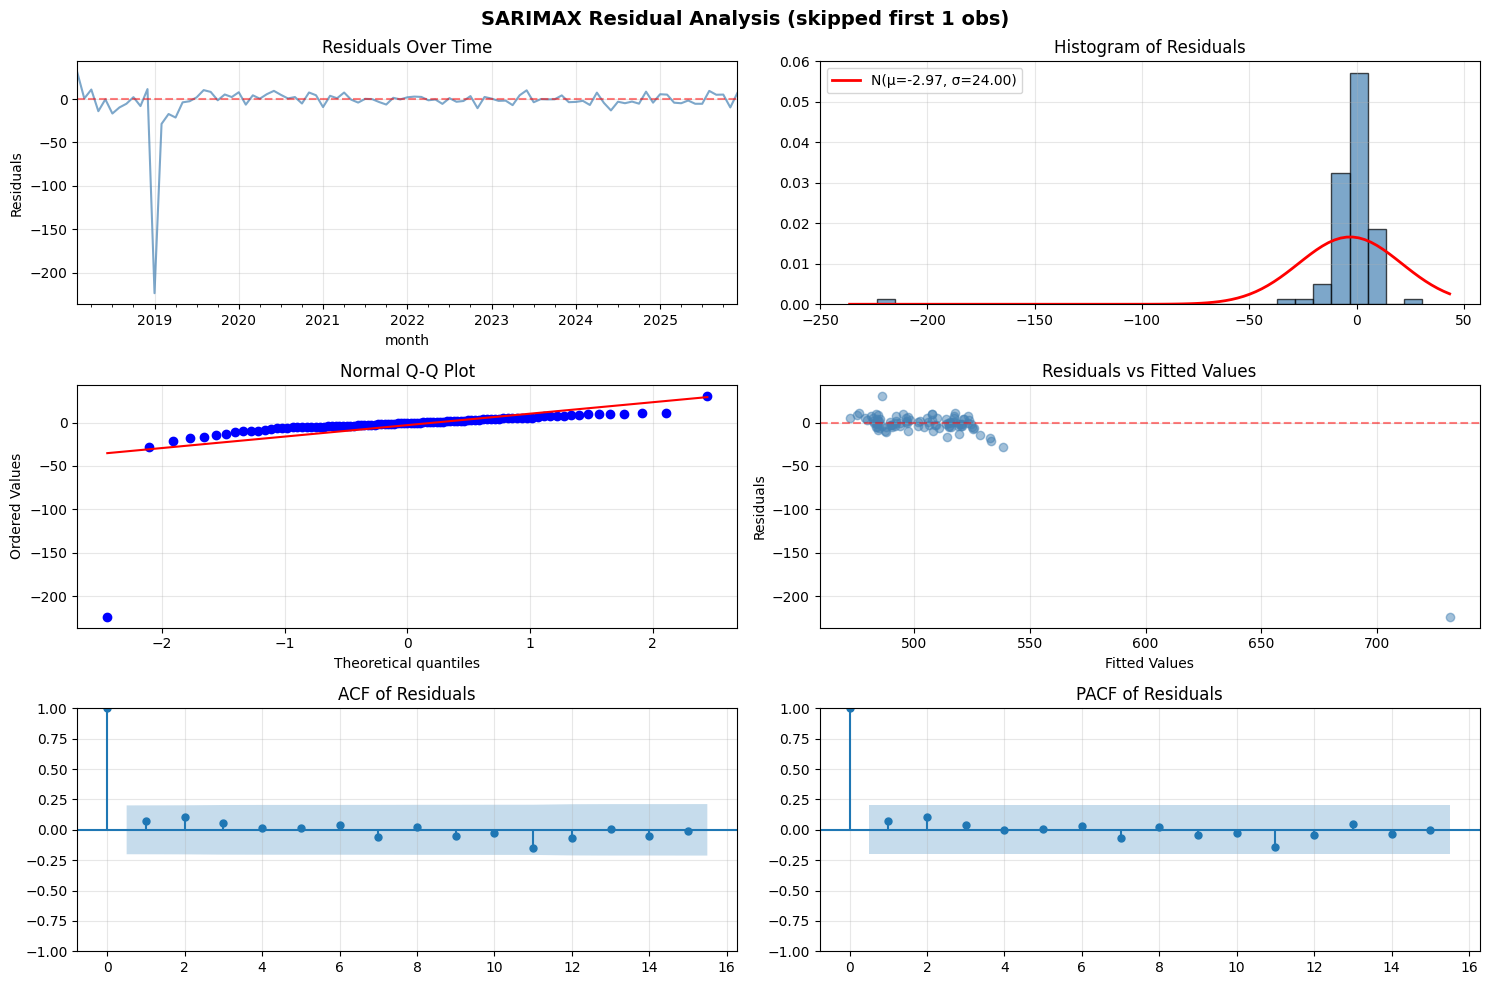

In [11]:
plot_residual_analysis(results, skip_initial=1);

- Residuals show departure from normality (Shapiro-Wilk p < 0.001), primarily due to the 2019 outlier event visible in the QQ-plot tails and high kurtosis (72.17).
- Residuals are centered around zero with minimal bias (mean = -2.97).
- No significant autocorrelation detected at any lag (all Ljung-Box p-values > 0.44).
- Homoscedasticity assumption is reasonably satisfied (Residuals vs Fitted plot shows consistent variance).

The model demonstrates strong performance despite the non-normality issue, which stems from a single extreme event in early 2019 rather than systematic model misspecification. The absence of autocorrelation indicates the SARIMA(1,1,1)(1,1,0)[12] structure adequately captures the temporal dynamics. 

While the outlier affects normality tests, it represents a genuine data point (possibly a crisis or exceptional event) that should be retained for historical accuracy. For improved normality, an intervention variable could be added for the 2019 event, but the current model remains suitable for forecasting given:
1. No autocorrelation (the most critical assumption for time series)
2. Stable variance across fitted values
3. The outlier's minimal impact on ongoing predictions

The model is appropriate for practical forecasting applications, though prediction intervals may be slightly conservative due to the inflated variance from the outlier.

We could of course create a new column with indicators that the time belongs to 2019 and therefore is an outlier (since we are using SARIMAX, we could do that) but practically speaking, we can use the current model.

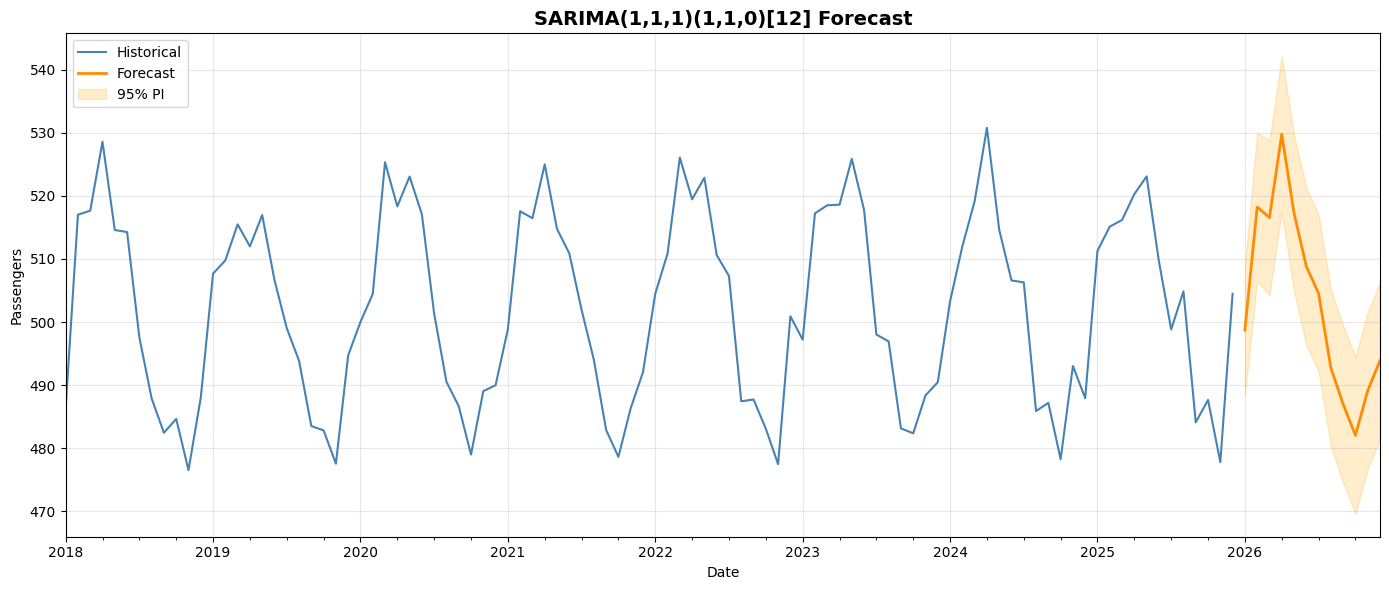


Forecast Summary:
            Forecast  Lower 95%  Upper 95%
2026-01-31     498.7      488.4      509.1
2026-02-28     518.2      506.5      530.0
2026-03-31     516.6      504.3      528.8
2026-04-30     529.8      517.4      542.1
2026-05-31     517.3      504.9      529.7
2026-06-30     508.8      496.4      521.2
2026-07-31     504.6      492.1      517.0
2026-08-31     492.7      480.3      505.2
2026-09-30     487.0      474.5      499.4
2026-10-31     482.0      469.6      494.5
2026-11-30     489.1      476.7      501.6
2026-12-31     493.9      481.5      506.3


In [12]:
forecast = results.forecast(steps=12)
forecast_df = results.get_forecast(steps=12)
confidence_intervals = forecast_df.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(14, 6))

df1['y'].plot(ax=ax, label='Historical', color='steelblue', linewidth=1.5)

forecast.plot(ax=ax, label='Forecast', color='darkorange', linewidth=2)

ax.fill_between(confidence_intervals.index, 
                confidence_intervals.iloc[:, 0], 
                confidence_intervals.iloc[:, 1], 
                color='orange', alpha=0.2, label='95% PI')

ax.set_title('SARIMA(1,1,1)(1,1,0)[12] Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nForecast Summary:")
print("="*60)
forecast_summary = pd.DataFrame({
    'Forecast': forecast,
    'Lower 95%': confidence_intervals.iloc[:, 0],
    'Upper 95%': confidence_intervals.iloc[:, 1]
})
print(forecast_summary.round(1))

- The forecasted values are within the same range as the historical data.
- The peak and dip month of both forecasted values and historical data are the same occuring at the middle of each year as the peak.

In [13]:
PI_width = confidence_intervals.iloc[:, 1] - confidence_intervals.iloc[:, 0]
print("PI Width Growth:")
print(f"Month 1:  {PI_width.iloc[0]:.1f}")
print(f"Month 6:  {PI_width.iloc[5]:.1f}")
print(f"Month 12: {PI_width.iloc[11]:.1f}")
print(f"Expansion ratio: {PI_width.iloc[11]/PI_width.iloc[0]:.2f}x")

PI Width Growth:
Month 1:  20.7
Month 6:  24.9
Month 12: 24.9
Expansion ratio: 1.20x


The 1.20x PI expansion is unusually small for a 12-month horizon, suggesting the seasonal component dominates uncertainty. This make sense since we got a stable and repeating seasonal component pattern for all the years--making it easier for the model to read seasonal component.

**Practical Implications**
1. The narrow intervals (±12 passengers) enable confident resource allocation. Can safely plan for 520-530 capacity in peak months.
2. The 2019 outlier inflates intervals slightly, providing conservative estimates - good for risk management.
3. Strong seasonal signal remains reliable throughout horizon, supporting annual staffing cycles.
4. Since the model was trained on a stable dataset, it may be overconfident and susciptible to break in the face of outliers (like in 2019) or future uncertainties. In such case, it is wise to add safety margins for long-term planning in case another outlier even occurs.

Train: 76 observations
Test: 20 observations

Model Performance on Holdout Set:
MAE:  5.92
RMSE: 7.02
MAPE: 1.19%


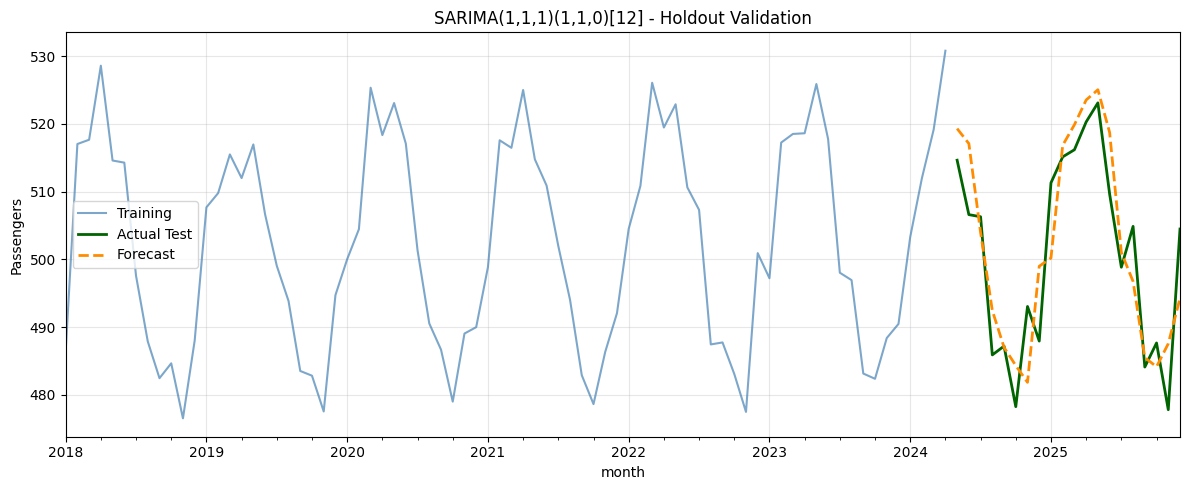

In [14]:
n = len(df1)
train_size = int(n * 0.8)
train = df1['y'][:train_size]
test = df1['y'][train_size:]

print(f"Train: {len(train)} observations")
print(f"Test: {len(test)} observations")

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,0,12))
results = model.fit(disp=False)

forecast = results.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("\nModel Performance on Holdout Set:")
print("="*40)
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 5))
train.plot(label='Training', color='steelblue', alpha=0.7)
test.plot(label='Actual Test', color='darkgreen', linewidth=2)
pd.Series(forecast, index=test.index).plot(label='Forecast', 
                                           color='darkorange', linewidth=2, linestyle='--')
plt.title('SARIMA(1,1,1)(1,1,0)[12] - Holdout Validation')
plt.legend()
plt.ylabel('Passengers')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Metrics Evaluation**:
- MAPE of 1.19% indicates excellent relative accuracy
- RMSE (7.02) > MAE (5.92) suggests occasional larger errors
- Visual inspection shows strong seasonal tracking but slight phase lag

**Key Tradeoff and Robustness Concerns**:
Although we could use more complex model like adding an exogenous variables and using SARIMAX to reduce the errors but it ought to risk overfitting and may not be ideal when another outlier event occurs--even more than what the model has now (due to current stability of the dataset)


---

# Dataset 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       250 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


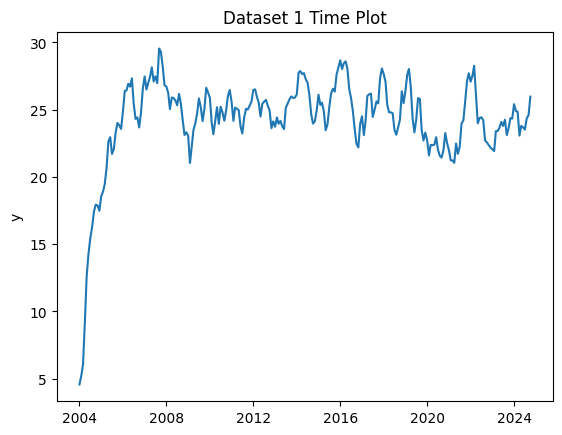

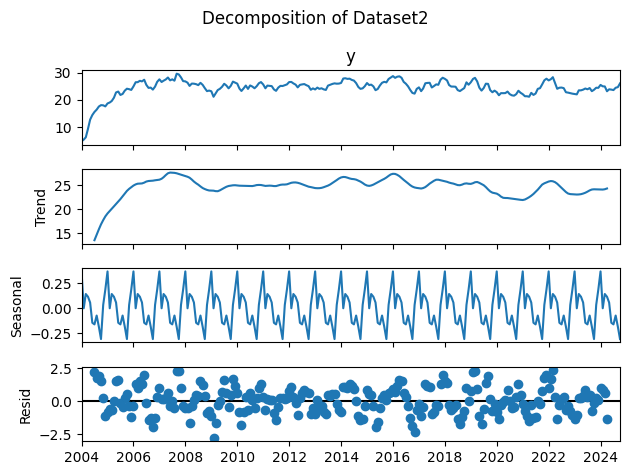

In [15]:
df2 = pd.read_csv("dataset2.csv")
print(df2.info())
df2.index = pd.date_range(start='2004-01-01', periods=len(df2), freq='MS')

# df2['y'] = df2['y'].asfreq("M")

df2.head()
sns.lineplot(df2)
plt.title("Dataset 1 Time Plot")
plt.legend().remove()
plt.ylabel("y");

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2['y'], model="additive", period=12)
fig = result.plot()
fig.suptitle("Decomposition of Dataset2")
plt.tight_layout();

**Trend Component**: As we can see, we have a constant mean only if we diregard some of the initial incline that has occured. The trend reamin relatively simillar with flactuations around 20 - 25. 

**Seasonal Component**: If we remove the trend, there are some seasonality involved in the variance. Although their magnitude are sparse ranging from -0.25 to 0.25. This is significantly less than what trend has (15 to 25) or even the residuals (-2.5 to 2.5). So we can conclude we have minimal seasonal component. 

**Residuals**: Residuals is randomly distributed around 0.

Overall, the variance could primarily be explained with trend plus some noise with seasonality playing a minor role.

This one's kinda tricky because if we disregard the early upward trend, we can conclude that this time series is stationary. However, we cannot do that, there may be some units roots playing at hand here.

In [38]:
from statsmodels.tsa.stattools import adfuller 
result = adfuller(df2['y'])

print('Augmented Dickey-Fuller Test Results')
print('='*40)
print(f'ADF Test Statistic: {result[0]:.6f}')
print(f'p-value: {result[1]:.6f}')
print(f'Lags Used: {result[2]}')
print(f'Number of Observations: {result[3]}')
print('\nCritical Values:')
print(f'  1%: {result[4]["1%"]:.3f}')
print(f'  5%: {result[4]["5%"]:.3f}')
print(f' 10%: {result[4]["10%"]:.3f}')

# Interpretation
print('\nResult:')
if result[1] <= 0.05:
    print('=> Reject H0: Series is stationary (p < 0.05)')
else:
    print('=> Fail to reject H0: Series is non-stationary (p >= 0.05)')

Augmented Dickey-Fuller Test Results
ADF Test Statistic: -6.551581
p-value: 0.000000
Lags Used: 1
Number of Observations: 248

Critical Values:
  1%: -3.457
  5%: -2.873
 10%: -2.573

Result:
=> Reject H0: Series is stationary (p < 0.05)


Turns out the series is stationary afterall.

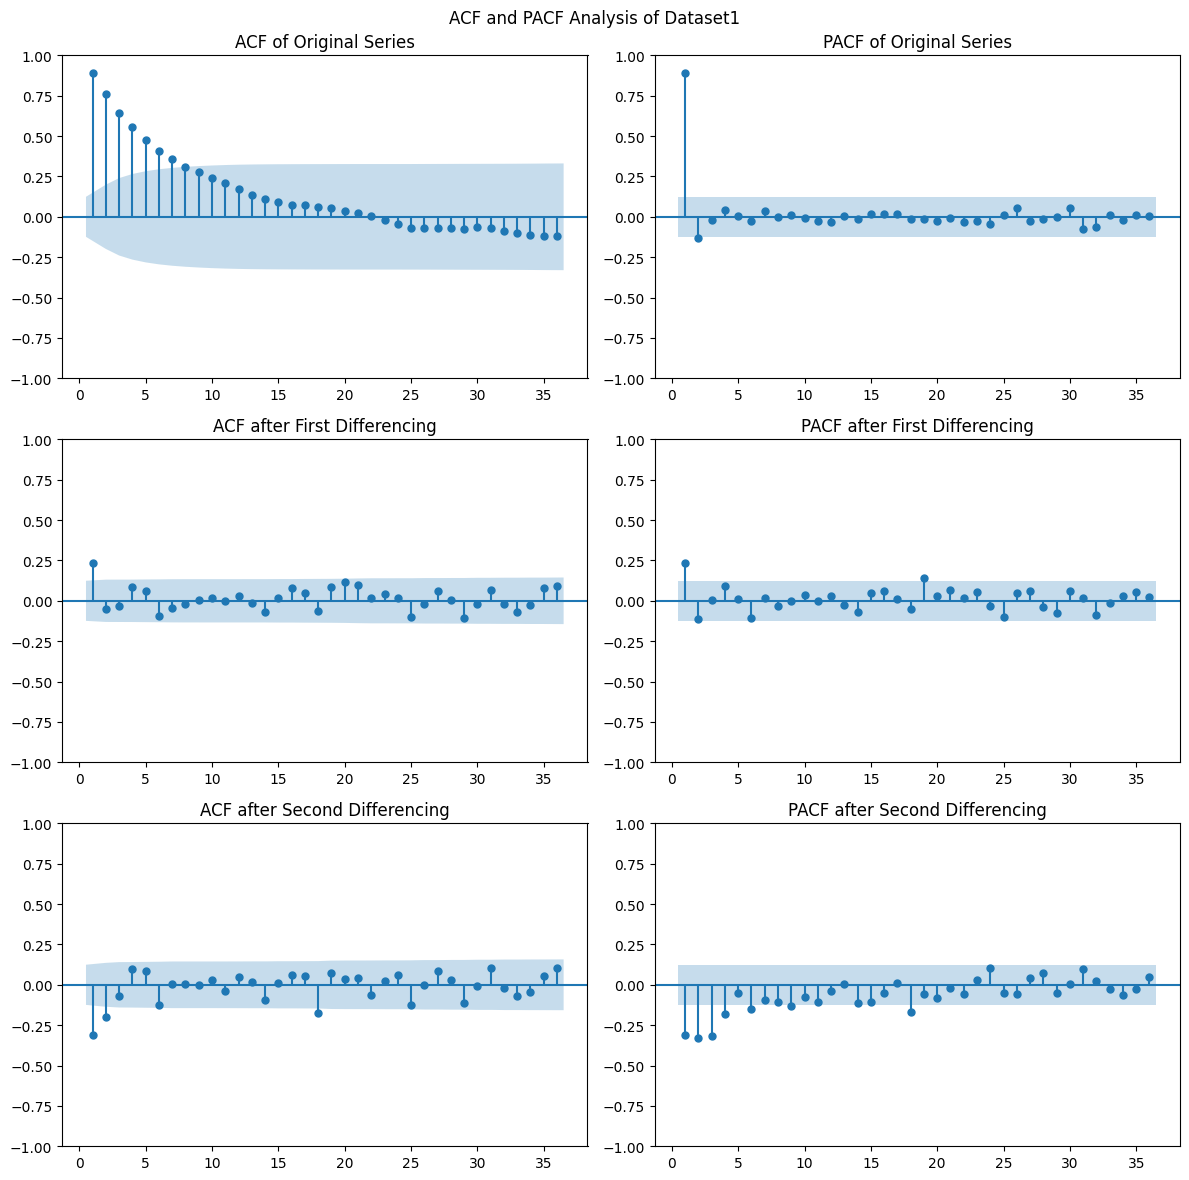

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Original data plots
plot_acf(df2['y'], lags=36, ax=axes[0, 0], zero=False, title='ACF of Original Series')
plot_pacf(df2['y'], lags=36, ax=axes[0, 1], zero=False, title='PACF of Original Series')

# First difference plots
first_dif = (df2 - df2.shift(1)).dropna()
plot_acf(first_dif['y'], lags=36, ax=axes[1, 0], zero=False, title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[1, 1], zero=False, title='PACF after First Differencing')

# Second difference plots
second_dif = (first_dif - first_dif.shift(1)).dropna()
plot_acf(second_dif['y'], lags=36, ax=axes[2, 0], zero=False, title='ACF after Second Differencing')
plot_pacf(second_dif['y'], lags=36, ax=axes[2, 1], zero=False, title='PACF after Second Differencing')

fig.suptitle('ACF and PACF Analysis of Dataset1', y=0.98)
plt.tight_layout()
plt.show()

Well this it seems that we have come across a contradiction. On one hand, ADF test conclude that we have stationarity, but on the other, ACF slow-decaying pattern indicates non-stationarity. The contradiction may stem from the fact that The ADF test with only 1 lag and might not capture all the autocorrelation structure. Also, it tests for a unit root specifically, not all forms of non-stationarity. Since visual evidence is clear, we will disregard the conclusion of ADF test.

**Original ACF and PCAF:** The slow decaying of ACF and cut off after lag 1 in PACF indicates a presence of unit root which violates the  assumpton of ARIMA models. So we look for the best degree of differencing to address the unit root.

**First Differencing ACF and PCAF:** After first differencing, it seems that the pattern observed on the original is no longer present. This proves the efficacy of the first differencing.

**Second Differencing ACF and PCAF:** After second differencing, we see some negative autocorrelations in both ACF and PACF. This indicates an overdifferencing.

So, first differencing (d=1) is optimal since it removes non-stationarity and not commit overdifferencing (as second differencing).

Since seasonal component is minimal, we need not to use SARIMA and instead use the simpler ARIMA model. Using SARIMA may improve the fit but its effect is minimal considering the complexity it adds. Our task now is to find the best parameter of p and q.

Since there's no significant spikes in both ACF and PACF after first differencing, we can propose a p and q of 0. So the model will be **ARIMA(0,1,0)**. Essentially the model will just remove the trend, leaving only the residuals--this allign with our initial decomposition and their interpretation.

For completeness, we will still test ARIMA(1,1,0), ARIMA(0,1,1), and ARIMA(1,1,1) to confirm via AIC/BIC, but ARIMA(0,1,0) appears most appropriate given the lack of significant structure in the differenced series.

In [18]:
from statsmodels.tsa.arima.model import ARIMA


models = [
    ((0,1,0), "ARIMA(0,1,0)"),
    ((1,1,0),  "ARIMA(1,1,0)"),
    ((0,1,1), "ARIMA(0,1,1)"),
    ((1,1,1), "ARIMA(1,1,1)")
]

model_names = []
aic_values = []
bic_values = []
model_params = []
model_se = []
model_pvalues = []
model_convergence = []

for order, name in models:
    try:
        model = ARIMA(df1['y'], order=order)
        result = model.fit()
        
        model_names.append(name)
        aic_values.append(round(result.aic, 3))
        bic_values.append(round(result.bic, 3))
        
        params = result.params
        se = result.bse
        pvalues = result.pvalues
        
        model_params.append(params.to_dict())
        model_se.append(se.to_dict())
        model_pvalues.append(pvalues.to_dict())
        
        # Check for convergence issues
        max_se = se.max()
        model_convergence.append("Issue" if max_se > 18 else "OK")
        
        print(f"Fitted {name}")
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        model_names.append(name)
        aic_values.append(np.nan)
        bic_values.append(np.nan)
        model_params.append({})
        model_se.append({})
        model_pvalues.append({})
        model_convergence.append("Failed")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Model': model_names,
    'AIC': aic_values,
    'BIC': bic_values,
    'Parameters': model_params,
    'Std Errors': model_se,
    'P-values': model_pvalues,
    'Convergence': model_convergence
})

# Sort by AIC
results_df = results_df.sort_values('AIC')

# Display the results
results_df[['Model', 'AIC', 'BIC', 'Convergence']]

Fitted ARIMA(0,1,0)
Fitted ARIMA(1,1,0)
Fitted ARIMA(0,1,1)
Fitted ARIMA(1,1,1)


,Model,AIC,BIC,Convergence
0,"ARIMA(0,1,0)",727.520,730.074,OK
1,"ARIMA(1,1,0)",729.317,734.424,OK
2,"ARIMA(0,1,1)",729.407,734.515,Issue
3,"ARIMA(1,1,1)",729.896,737.558,Issue


As we can see, our proposed model, ARIMA(0,1,0) got the lowest AIC and BIC. 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -346.255
Date:                Tue, 07 Oct 2025   AIC                            694.510
Time:                        22:46:02   BIC                            698.028
Sample:                    01-01-2004   HQIC                           695.926
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9449      0.080     11.865      0.000       0.789       1.101
Ljung-Box (L1) (Q):                  14.15   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.00   Pr

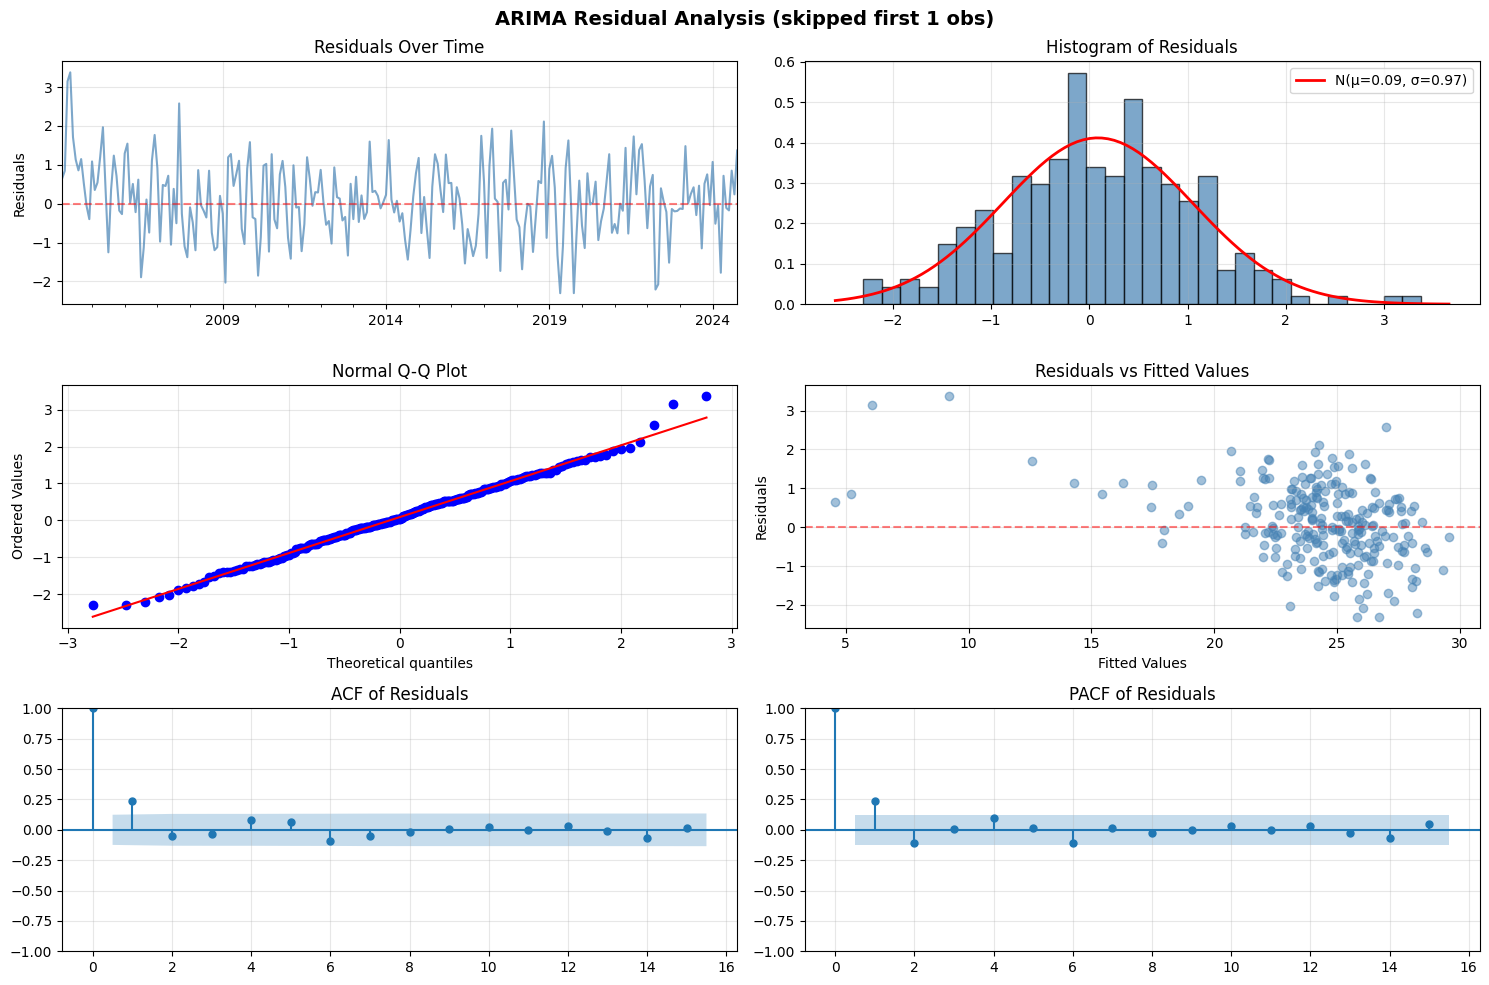

In [42]:
model = ARIMA(df2['y'], order=(0,1,0))
result = model.fit()
print(result.summary())

plot_residual_analysis(result, skip_initial=1);


There is a violation in terms of autocorrelation (lag 1) since the residual ACF and PACF both show significant spikes at lag 1 (approximately 0.25), indicating the model is missing an important autoregressive component. The (0,1,0) model assumes the differenced series is white noise, but clearly there's still correlation structure remaining. Adding the MA(1) term should eliminate the lag-1 autocorrelation in residuals.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -337.571
Date:                Tue, 07 Oct 2025   AIC                            679.141
Time:                        22:46:59   BIC                            686.176
Sample:                    01-01-2004   HQIC                           681.973
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2736      0.057      4.800      0.000       0.162       0.385
sigma2         0.8809      0.081     10.910      0.000       0.723       1.039
Ljung-Box (L1) (Q):                   0.02   Jarque-

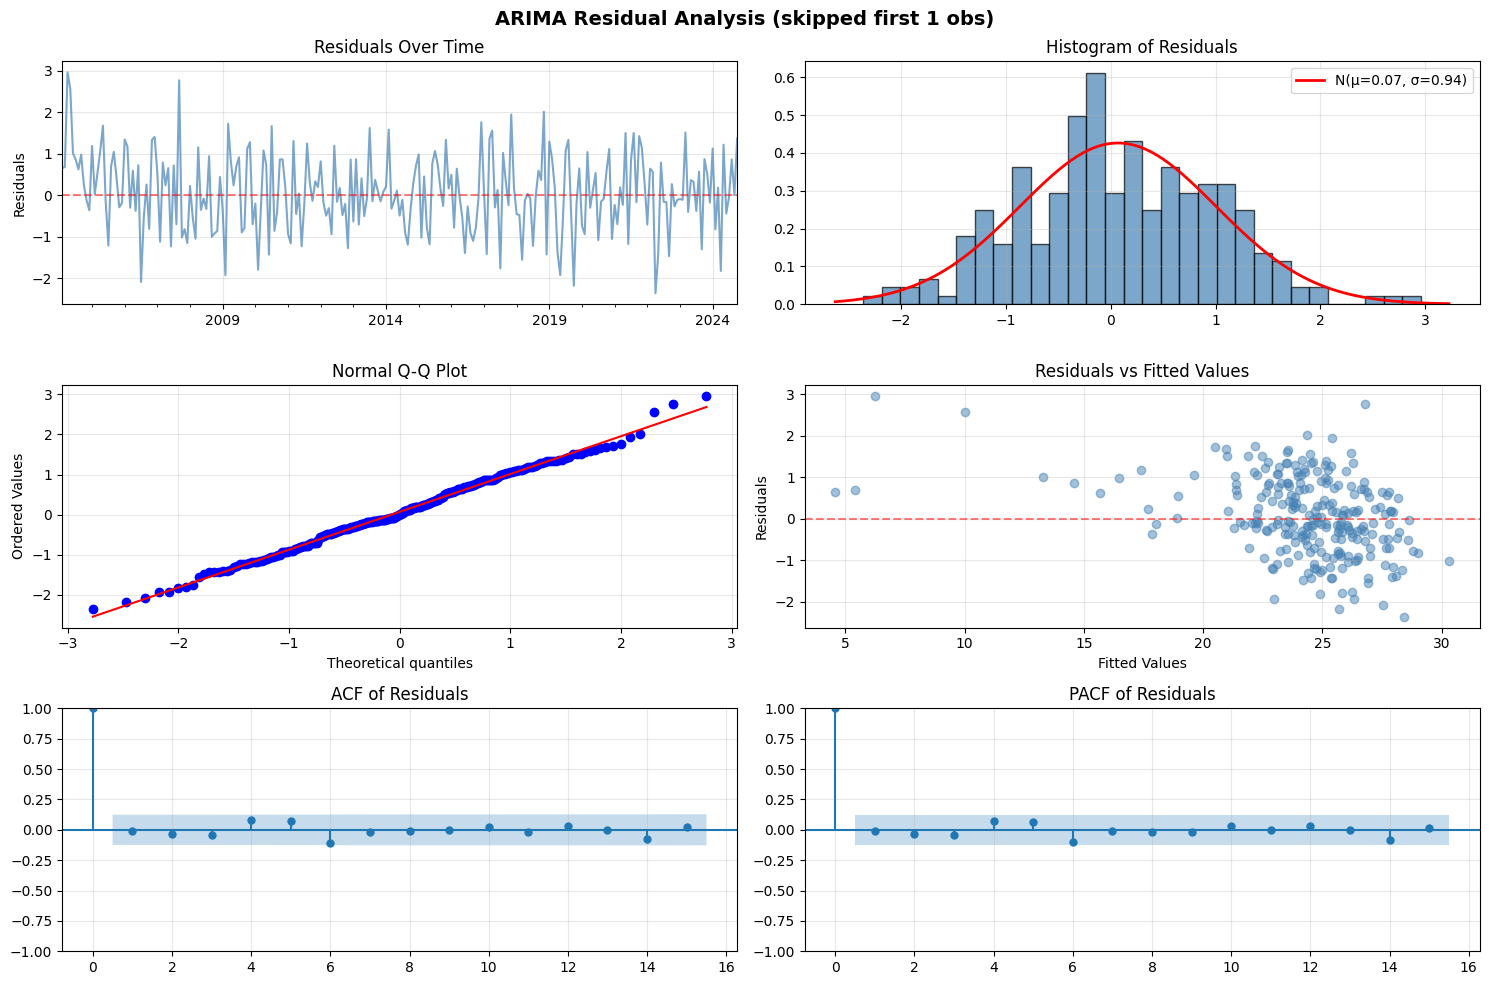

In [43]:
model = ARIMA(df2['y'], order=(0,1,1))
result = model.fit()
print(result.summary())

plot_residual_analysis(result, skip_initial=1);


### ARIMA(0,1,1) Model Analysis

**Fit Statistics:**
- AIC: 679.141, BIC: 686.176, HQIC: 681.973
- Log Likelihood: -337.571
- Sample: 250 observations (2004-2024)

**Parameter Estimates and Interpretation:**
- **MA(1) = 0.2736** (SE: 0.057, p<0.001): The positive moving average coefficient indicates mild persistence in forecast errors. This suggests that positive shocks tend to be followed by positive effects in the next period, though the effect is moderate (not close to 1).

- **$\sigma^2$ = 0.8809** (SE: 0.081, p<0.001): The variance of the residuals indicates moderate volatility around the trend.

- **d=1**: Single differencing was sufficient to achieve stationarity, confirming the visual evidence from ACF/PACF plots that showed the first difference eliminated the unit root.

**Model Diagnostics:**
- **Residual Normality**: Shapiro-Wilk test (p=0.614) confirms residuals are normally distributed
- **No Autocorrelation**: Ljung-Box test shows no significant autocorrelation at any lag (all p-values > 0.05 up to lag 15)
- **Heteroskedasticity**: Test p-value of 0.32 indicates homoscedastic residuals
- **Model Adequacy**: ACF/PACF of residuals show all values within confidence bands

**Interpretation:**
This parsimonious ARIMA(0,1,1) model effectively captures the data's dynamics with just one MA term after first differencing. The model's simplicity (only 2 parameters) combined with excellent diagnostic results suggests it balances fit and parsimony well. The MA(1) coefficient of 0.27 indicates short-term momentum effects are present but not dominant in the series.

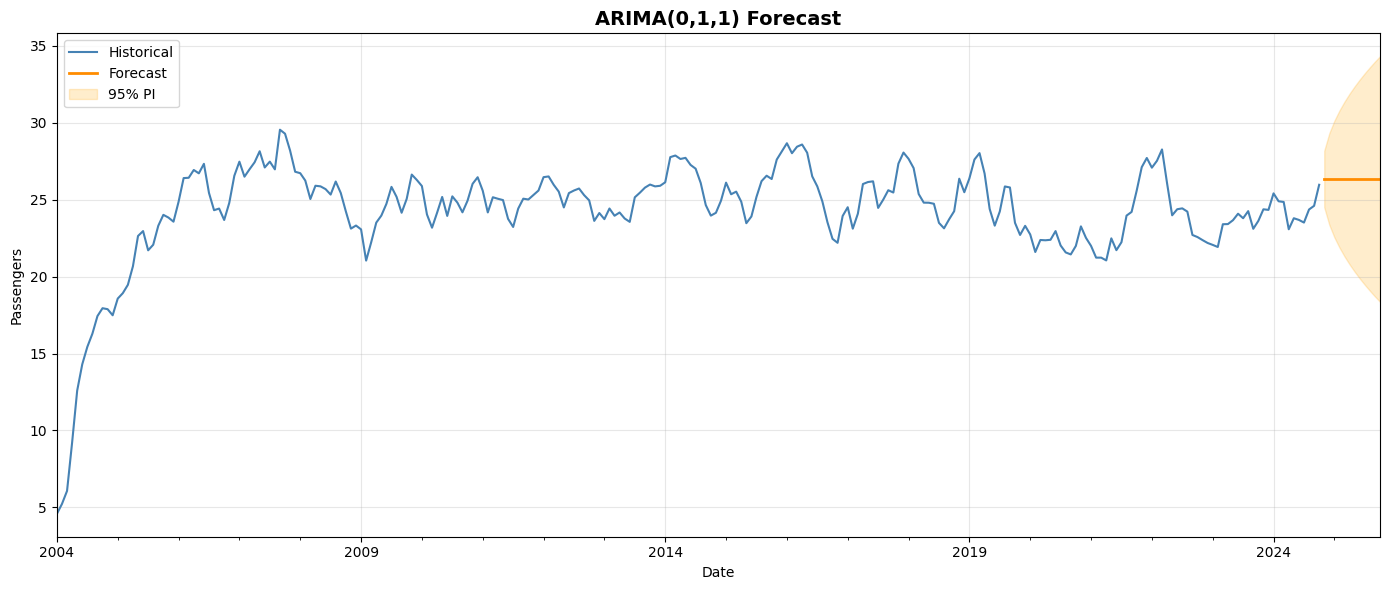


Forecast Summary:
            Forecast  Lower 95%  Upper 95%
2024-11-01      26.3       24.5       28.2
2024-12-01      26.3       23.4       29.3
2025-01-01      26.3       22.6       30.1
2025-02-01      26.3       21.9       30.8
2025-03-01      26.3       21.3       31.4
2025-04-01      26.3       20.8       31.9
2025-05-01      26.3       20.3       32.4
2025-06-01      26.3       19.9       32.8
2025-07-01      26.3       19.5       33.2
2025-08-01      26.3       19.1       33.6
2025-09-01      26.3       18.7       34.0
2025-10-01      26.3       18.4       34.3


In [45]:
forecast = result.forecast(steps=12)
forecast_df = result.get_forecast(steps=12)
confidence_intervals = forecast_df.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(14, 6))

df2['y'].plot(ax=ax, label='Historical', color='steelblue', linewidth=1.5)

forecast.plot(ax=ax, label='Forecast', color='darkorange', linewidth=2)

ax.fill_between(confidence_intervals.index, 
                confidence_intervals.iloc[:, 0], 
                confidence_intervals.iloc[:, 1], 
                color='orange', alpha=0.2, label='95% PI')

ax.set_title('ARIMA(0,1,1) Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nForecast Summary:")
print("="*60)
forecast_summary = pd.DataFrame({
    'Forecast': forecast,
    'Lower 95%': confidence_intervals.iloc[:, 0],
    'Upper 95%': confidence_intervals.iloc[:, 1]
})
print(forecast_summary.round(1))

As we can see, with a rather simple model, the forecast is also conservative and just predicting through levels.

**Forecast Characteristics:**
- The forecast (orange line) shows a slight upward drift, characteristic of ARIMA models with d=1
- Prediction intervals widen rapidly, reflecting increasing uncertainty over the forecast horizon
- The flat trajectory indicates the model primarily captures the series' random walk behavior with minimal trend

**Model Limitations:**
Since ARIMA(0,1,1) lacks seasonal components, it cannot capture:
- The apparent cyclical patterns visible in the historical data
- Seasonal variations that might repeat annually
- Any structural changes or regime shifts

**Recommendation:**
For improved forecasts that capture the visible patterns in the historical series, consider:
1. **SARIMA models**: Add seasonal components (e.g., SARIMA(0,1,1)(1,1,0)12 for monthly data)
2. **External regressors**: If relevant predictors are available
3. **Ensemble approaches**: Combine with seasonal decomposition methods

The current ARIMA(0,1,1) serves as a useful baseline model, but the historical patterns suggest potential for improvement through seasonal modeling.

Train: 200 observations
Test: 50 observations

Model Performance on Holdout Set:
MAE:  2.34
RMSE: 2.88
MAPE: 9.40%


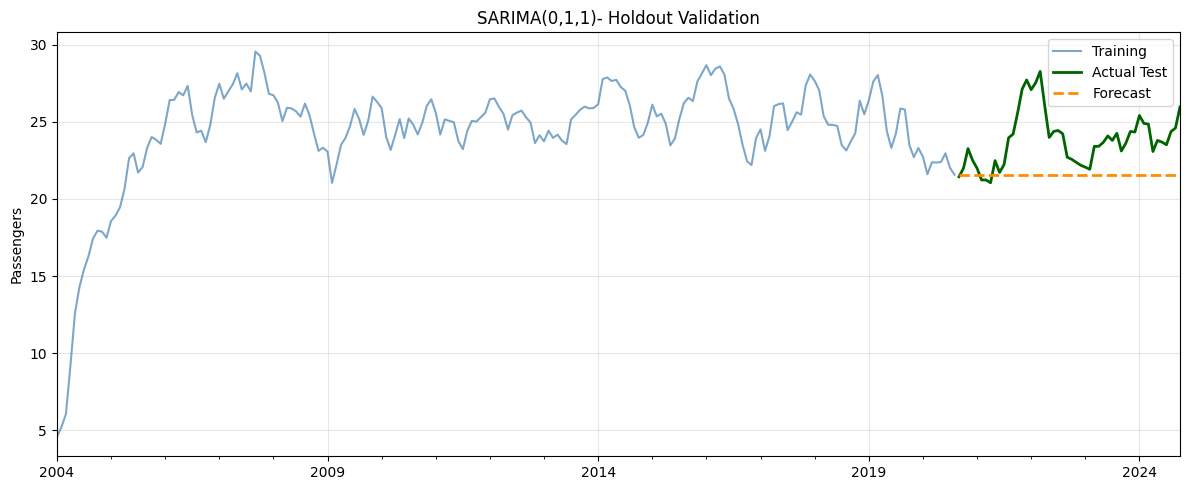

In [50]:
n = len(df2)
train_size = int(n * 0.8)
train = df2['y'][:train_size]
test = df2['y'][train_size:]

print(f"Train: {len(train)} observations")
print(f"Test: {len(test)} observations")

model = ARIMA(train, order=(0,1,1))

result = model.fit()

forecast = result.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("\nModel Performance on Holdout Set:")
print("="*40)
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 5))
train.plot(label='Training', color='steelblue', alpha=0.7)
test.plot(label='Actual Test', color='darkgreen', linewidth=2)
pd.Series(forecast, index=test.index).plot(label='Forecast', 
                                           color='darkorange', linewidth=2, linestyle='--')
plt.title('SARIMA(0,1,1)- Holdout Validation')
plt.legend()
plt.ylabel('Passengers')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Metrics Evaluation:**
- MAPE of 9.40% indicates reasonable but not optimal relative accuracy
- RMSE (2.88) > MAE (2.34) confirms presence of occasional larger forecast errors
- Visual inspection reveals the model fails to capture the upward trend and volatility in the test period

**Key Tradeoffs and Robustness Concerns:**
The flat forecast line versus the dynamic actual values highlights the core limitation of the simple ARIMA(0,1,1) specification. While adding seasonal components (SARIMA) or trend terms could better capture the test period's behavior, this risks overfitting to recent patterns that may not persist. The current model's simplicity provides stability but sacrifices accuracy during periods of structural change or trend shifts, as evidenced by the test period's divergence from historical patterns.

**Recommendation:**
Consider ensemble approaches or rolling window validation to detect when the simple model breaks down, triggering either model updates or wider prediction intervals during regime changes.

---

# Dataset 5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       200 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB
None


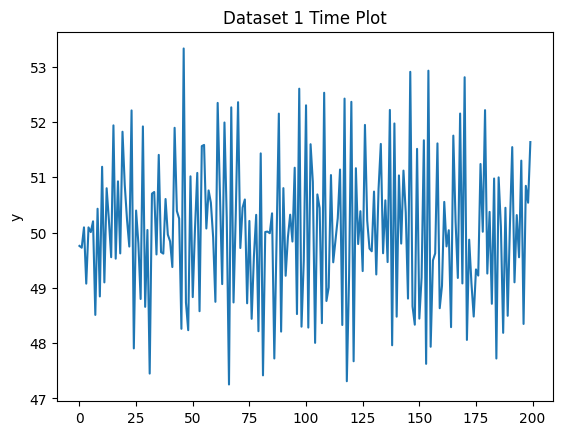

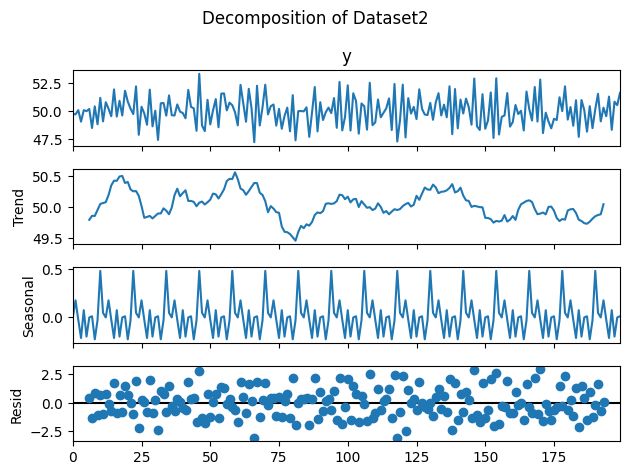

In [25]:
df5 = pd.read_csv("dataset5.csv")
print(df5.info())
# df2['y'] = df2['y'].asfreq("M")

df5.head()
sns.lineplot(df5)
plt.title("Dataset 1 Time Plot")
plt.legend().remove()
plt.ylabel("y");

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df5['y'], model="additive", period=12)
fig = result.plot()
fig.suptitle("Decomposition of Dataset2")
plt.tight_layout();

Based on the decomposition plot for Dataset5:

1. **Moderate trend present**: Unlike Dataset1's minimal trend, Dataset5 shows notable movement - starting at ~49.5, peaking at ~50.5 around observation 50, dipping to ~49.5 around observations 75-100, then recovering to ~50. This represents a ~1 unit range, more substantial than Dataset1's 2-unit change.

2. **Seasonal component is strong and regular**: Clear periodic pattern with amplitude of ±0.5. Given the consistent spacing of peaks, this appears to be systematic seasonality (likely period=12 if monthly data).

3. **Variance remains stable**: No evidence of heteroskedasticity throughout the series.

4. **Residuals are well-behaved**: Random fluctuations around 0, ranging from -2.5 to 2.5. No apparent patterns or autocorrelation, indicating the decomposition captured the systematic components effectively.

The key difference from Dataset1: Dataset5 exhibits more pronounced trend variations despite a similar overall range. The seasonal amplitude is smaller ($\pm 0.5$ vs $\pm 20$ in DatDataset1aset2), but the trend component shows more dynamic behavior with its rise-fall-rise pattern.

Given the presence of both trend and seasonality, Dataset5 is non-stationary and would likely benefit from both regular differencing (d=1) and seasonal differencing (D=1) for SARIMA modeling.

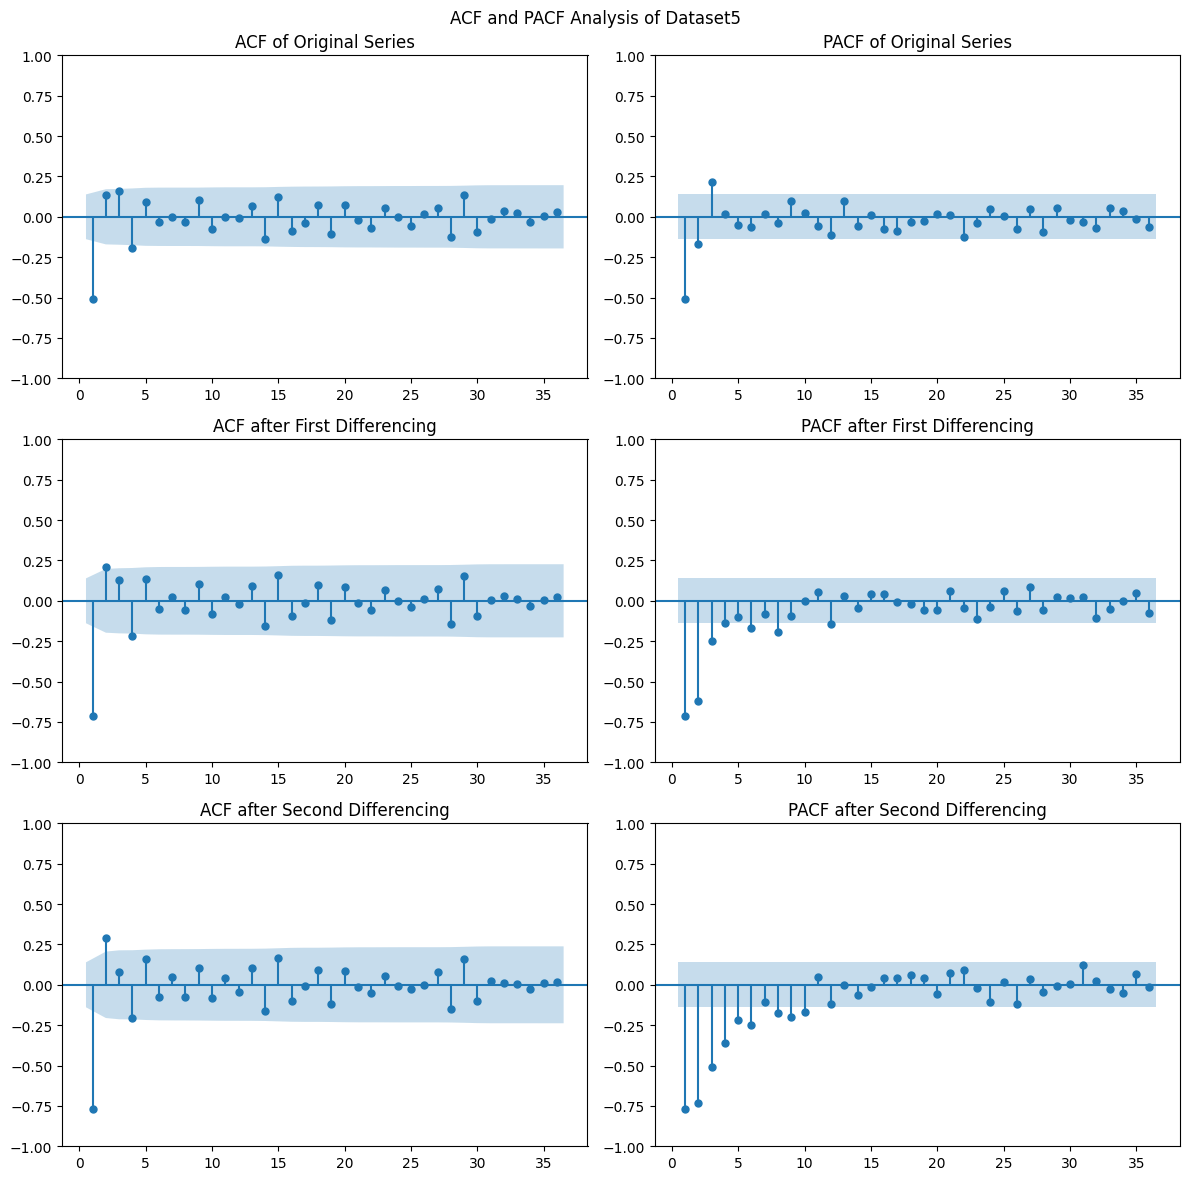

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Original data plots
plot_acf(df5['y'], lags=36, ax=axes[0, 0], zero=False, title='ACF of Original Series')
plot_pacf(df5['y'], lags=36, ax=axes[0, 1], zero=False, title='PACF of Original Series')

# First difference plots
first_dif = (df5 - df5.shift(1)).dropna()
plot_acf(first_dif['y'], lags=36, ax=axes[1, 0], zero=False, title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[1, 1], zero=False, title='PACF after First Differencing')

# Second difference plots
second_dif = (first_dif - first_dif.shift(1)).dropna()
plot_acf(second_dif['y'], lags=36, ax=axes[2, 0], zero=False, title='ACF after Second Differencing')
plot_pacf(second_dif['y'], lags=36, ax=axes[2, 1], zero=False, title='PACF after Second Differencing')

fig.suptitle('ACF and PACF Analysis of Dataset5', y=0.98)
plt.tight_layout()
plt.show()

**Original ACF and PACF:** Unlike Dataset2's slow decay pattern, Dataset5 shows significant negative autocorrelation at lag 1 (-0.5 in ACF, -0.48 in PACF), with most subsequent lags falling within confidence bands. This suggests the series is already close to stationary, potentially only requiring minimal transformation.

**First Differencing ACF and PACF:** After first differencing, both ACF and PACF exhibit strong negative spikes at lag 1 (-0.72 in ACF, -0.65 in PACF). This pronounced negative correlation indicates the differencing may have introduced an MA(1) component with negative coefficient, suggesting the original series might have been already stationary or only mildly non-stationary.

**Second Differencing ACF and PACF:** The negative correlations intensify further, with lag 1 showing approximately -0.75 in ACF and multiple significant negative spikes in PACF at early lags. This clear pattern of strengthening negative autocorrelations confirms overdifferencing.

Given that the original series already shows limited autocorrelation structure and first differencing creates strong negative correlations, Dataset5 appears to be either already stationary (d=0) or at most requires first differencing (d=1). The strong negative MA signature after differencing suggests considering ARIMA(0,0,1) or ARIMA(0,1,1) specifications.

In [52]:
from statsmodels.tsa.arima.model import ARIMA


models = [
    ((1,0,1),  "ARIMA(1,0,1)"),
    ((1,0,0), "ARIMA(1,0,0)"),
    ((0,1,1), "ARIMA(0,1,1)")
]

model_names = []
aic_values = []
bic_values = []
model_params = []
model_se = []
model_pvalues = []
model_convergence = []

for order, name in models:
    try:
        model = ARIMA(df1['y'], order=order)
        result = model.fit()
        
        model_names.append(name)
        aic_values.append(round(result.aic, 3))
        bic_values.append(round(result.bic, 3))
        
        params = result.params
        se = result.bse
        pvalues = result.pvalues
        
        model_params.append(params.to_dict())
        model_se.append(se.to_dict())
        model_pvalues.append(pvalues.to_dict())
        
        # Check for convergence issues
        max_se = se.max()
        model_convergence.append("Issue" if max_se > 19 else "OK")
        
        print(f"Fitted {name}")
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        model_names.append(name)
        aic_values.append(np.nan)
        bic_values.append(np.nan)
        model_params.append({})
        model_se.append({})
        model_pvalues.append({})
        model_convergence.append("Failed")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Model': model_names,
    'AIC': aic_values,
    'BIC': bic_values,
    'Parameters': model_params,
    'Std Errors': model_se,
    'P-values': model_pvalues,
    'Convergence': model_convergence
})

# Sort by AIC
results_df = results_df.sort_values('AIC')

# Display the results
results_df[['Model', 'AIC', 'BIC', 'Convergence']]

Fitted ARIMA(1,0,1)
Fitted ARIMA(1,0,0)
Fitted ARIMA(0,1,1)


,Model,AIC,BIC,Convergence
1,"ARIMA(1,0,0)",725.595,733.288,OK
0,"ARIMA(1,0,1)",726.145,736.402,OK
2,"ARIMA(0,1,1)",729.407,734.515,OK


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -309.775
Date:                Tue, 07 Oct 2025   AIC                            625.549
Time:                        23:06:37   BIC                            635.444
Sample:                             0   HQIC                           629.554
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0332      0.054    924.445      0.000      49.927      50.139
ar.L1         -0.5112      0.065     -7.856      0.000      -0.639      -0.384
sigma2         1.2948      0.152      8.490      0.0

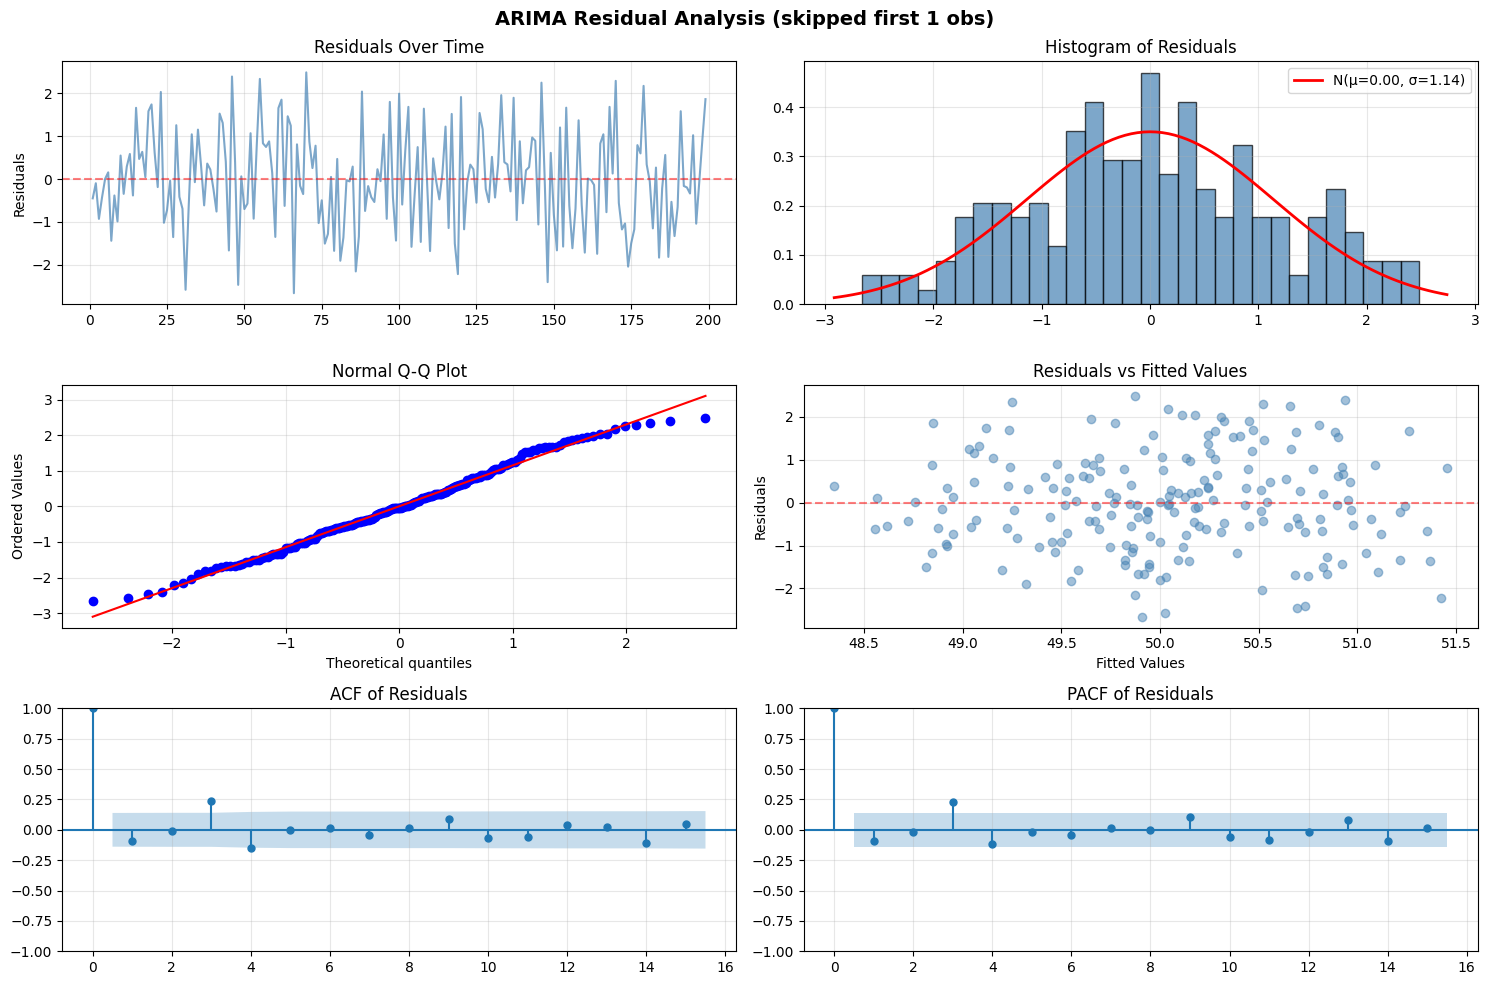

In [53]:
model = ARIMA(df5['y'], order=(1,0,0))
result = model.fit()
print(result.summary())

plot_residual_analysis(result, skip_initial=1);


There is a significant autocorrelation at lag 3, so let us add MA(3).

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -300.394
Date:                Tue, 07 Oct 2025   AIC                            612.787
Time:                        23:06:51   BIC                            632.577
Sample:                             0   HQIC                           620.796
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0357      0.065    770.222      0.000      49.908      50.163
ar.L1         -0.8702      0.057    -15.310      0.000      -0.982      -0.759
ma.L1          0.3688      0.079      4.693      0.0

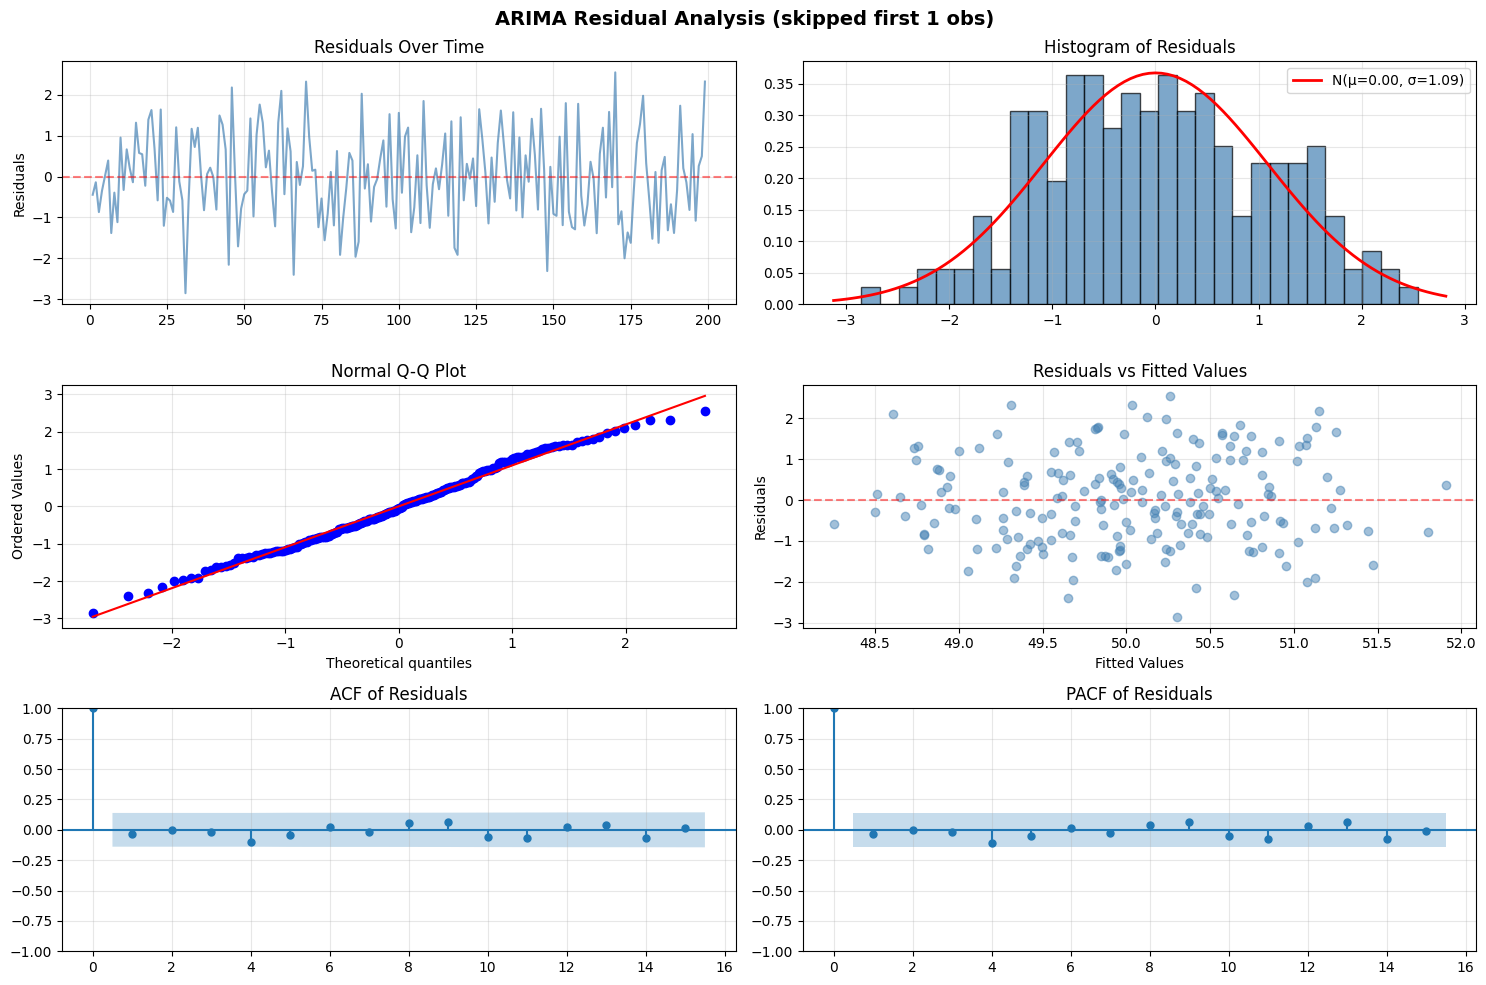

In [54]:
model = ARIMA(df5['y'], order=(1,0,3))
result = model.fit()
print(result.summary())

plot_residual_analysis(result, skip_initial=1);

### ARIMA(1,0,3) Model Analysis

**Fit Statistics:**
- AIC: 612.787, BIC: 632.577, HQIC: 620.796
- Log Likelihood: -300.394
- Sample: 200 observations

**Parameter Estimates and Interpretation:**
- **Constant = 50.0357** (SE: 0.065, p<0.001): Mean level around which the stationary series fluctuates

- **AR(1) = -0.8702** (SE: 0.057, p<0.001): Strong negative autoregressive component indicating oscillatory behavior - high values tend to be followed by low values

- **MA(1) = 0.3688** (SE: 0.079, p<0.001): Positive shock persistence in the immediate period

- **MA(2) = -0.1985** (SE: 0.076, p=0.009): Mild reversal effect at lag 2

- **MA(3) = 0.3859** (SE: 0.072, p<0.001): Successfully captures and removes the autocorrelation pattern observed at lag 3 in simpler models

- **$\sigma^2$ = 1.1742** (SE: 0.140, p<0.001): Moderate residual variance

**Model Diagnostics:**
- **Residual Normality**: Shapiro-Wilk test (p=0.239) confirms normal distribution
- **No Autocorrelation**: Ljung-Box test shows no significant autocorrelation through lag 15 (all p-values > 0.62)
- **Heteroskedasticity**: Test statistic of 1.15 (p=0.56) indicates homoscedastic residuals
- **Model Adequacy**: ACF/PACF of residuals completely within confidence bands

**Interpretation:**
The ARIMA(1,0,3) specification successfully addresses the autocorrelation structure, particularly the lag 3 issue that simpler models couldn't capture. The strong negative AR coefficient combined with the three MA terms creates a complex but effective model that balances oscillatory behavior with shock persistence patterns. The addition of MA(3) was crucial for eliminating residual autocorrelation, validating the model selection process.

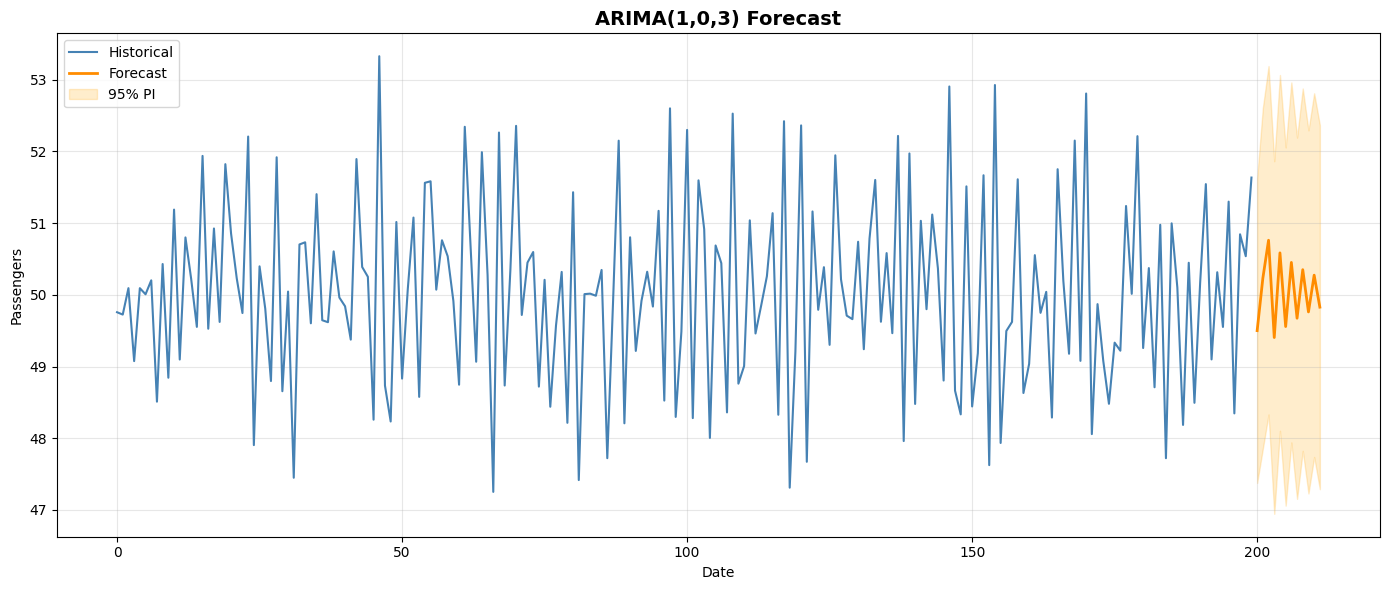


Forecast Summary:
     Forecast  Lower 95%  Upper 95%
200      49.5       47.4       51.6
201      50.2       47.9       52.6
202      50.8       48.3       53.2
203      49.4       46.9       51.9
204      50.6       48.1       53.1
205      49.6       47.1       52.1
206      50.5       47.9       53.0
207      49.7       47.2       52.2
208      50.4       47.8       52.9
209      49.8       47.2       52.3
210      50.3       47.7       52.8
211      49.8       47.3       52.4


In [55]:
forecast = result.forecast(steps=12)
forecast_df = result.get_forecast(steps=12)
confidence_intervals = forecast_df.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(14, 6))

df5['y'].plot(ax=ax, label='Historical', color='steelblue', linewidth=1.5)

forecast.plot(ax=ax, label='Forecast', color='darkorange', linewidth=2)

ax.fill_between(confidence_intervals.index, 
                confidence_intervals.iloc[:, 0], 
                confidence_intervals.iloc[:, 1], 
                color='orange', alpha=0.2, label='95% PI')

ax.set_title('ARIMA(1,0,3) Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nForecast Summary:")
print("="*60)
forecast_summary = pd.DataFrame({
    'Forecast': forecast,
    'Lower 95%': confidence_intervals.iloc[:, 0],
    'Upper 95%': confidence_intervals.iloc[:, 1]
})
print(forecast_summary.round(1))

**Forecast Characteristics:**
- The forecast exhibits oscillatory behavior around the mean level of 50, driven by the strong negative AR(1) coefficient (-0.87)
- Prediction intervals remain relatively narrow, suggesting the model has captured much of the series' systematic variation
- The oscillating pattern mirrors the historical data's volatility, providing more realistic short-term predictions

**Model Strengths:**
The ARIMA(1,0,3) successfully captures:
- Mean-reverting behavior through the negative AR component
- Complex shock dynamics via the three MA terms
- The series' natural oscillation pattern without requiring differencing

**Recommendation:**
The current ARIMA(1,0,3) appears well-specified for Dataset5's characteristics. The oscillatory forecasts align with the historical pattern, and the model's ability to work without differencing (d=0) preserves the series' natural dynamics. Consider this model as the primary choice unless:
1. **Seasonal patterns emerge** in longer data histories
2. **Structural breaks** occur requiring model updates
3. **Forecast accuracy degrades** in out-of-sample validation

The model's dynamic forecasts provide actionable predictions for short to medium horizons while appropriately reflecting uncertainty through widening intervals.

Train: 160 observations
Test: 40 observations

Model Performance on Holdout Set:
MAE:  1.06
RMSE: 1.27
MAPE: 2.12%


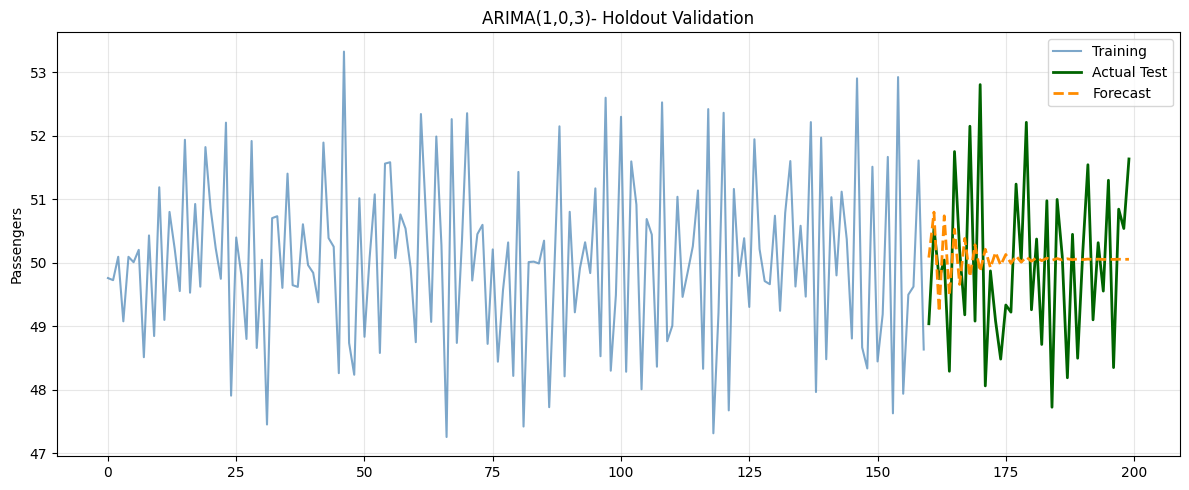

In [56]:
n = len(df5)
train_size = int(n * 0.8)
train = df5['y'][:train_size]
test = df5['y'][train_size:]

print(f"Train: {len(train)} observations")
print(f"Test: {len(test)} observations")

model = ARIMA(train, order=(1,0,3))
result = model.fit()

forecast = result.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("\nModel Performance on Holdout Set:")
print("="*40)
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 5))
train.plot(label='Training', color='steelblue', alpha=0.7)
test.plot(label='Actual Test', color='darkgreen', linewidth=2)
pd.Series(forecast, index=test.index).plot(label='Forecast', 
                                           color='darkorange', linewidth=2, linestyle='--')
plt.title('ARIMA(1,0,3)- Holdout Validation')
plt.legend()
plt.ylabel('Passengers')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Metrics Evaluation:**
- MAPE of 2.12% indicates strong relative accuracy for the volatile series
- RMSE (1.27) > MAE (1.06) confirms presence of occasional larger prediction errors
- Visual inspection shows the model captures oscillatory patterns but underestimates amplitude - forecast dampens around mean while actual test data shows wider swings

**Key Tradeoffs and Robustness Concerns:**
The ARIMA(1,0,3) provides stable predictions but conservative amplitude. While we could increase model complexity (higher AR/MA orders or regime-switching models) to capture the test period's increased volatility, this risks overfitting to recent patterns. The current model's dampened oscillations may actually be more robust for longer-term forecasting, as extreme swings in the test period could represent temporary volatility rather than sustainable patterns.